In [5]:
import pandas as pd

# В облаке файл лежит в корневой папке, путь C:\ больше не нужен
df = pd.read_csv('Sales Transaction v.4a.csv')

print(df.head())

  TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

   Price  Quantity  CustomerNo         Country  
0  21.47        12     17490.0  United Kingdom  
1  10.65        36     13069.0  United Kingdom  
2  11.53        12     13069.0  United Kingdom  
3  10.65        12     13069.0  United Kingdom  
4  11.94         6     13069.0  United Kingdom  


In [7]:
print(df.columns.tolist())

['TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Price', 'Quantity', 'CustomerNo', 'Country', 'Revenue']


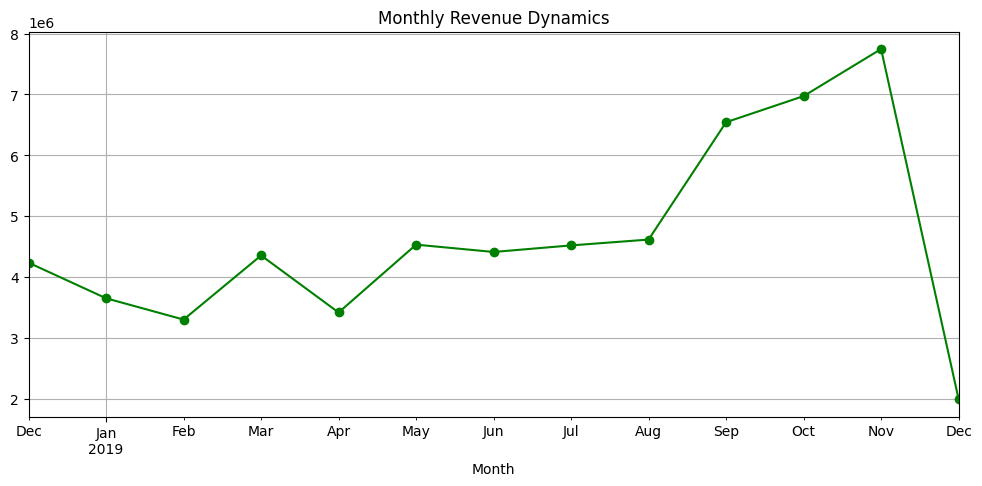

/tmp/ipython-input-2471961770.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


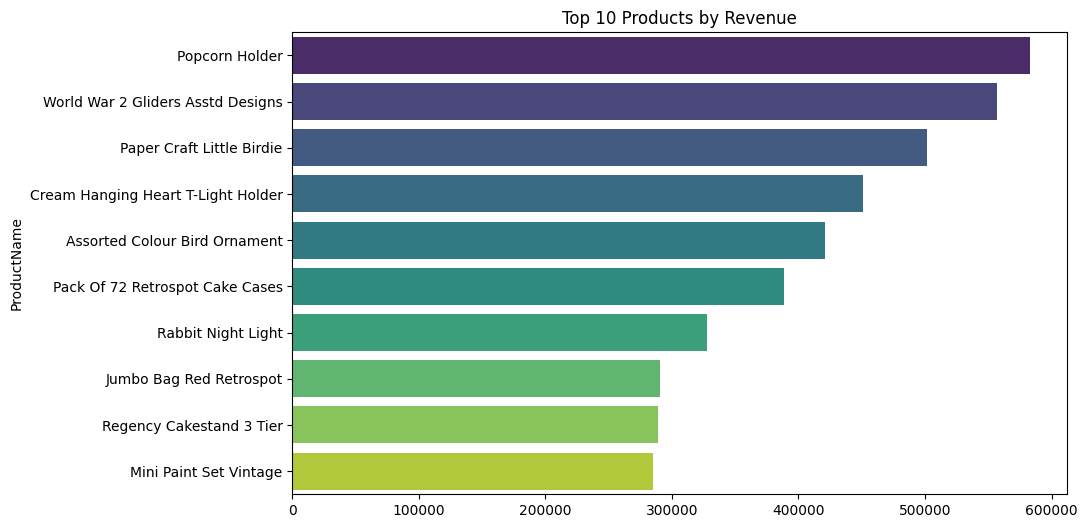

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Приведение типов
df['Date'] = pd.to_datetime(df['Date'])

# 1. Динамика выручки по месяцам
df['Month'] = df['Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Revenue'].sum()

plt.figure(figsize=(12, 5))
monthly_sales.plot(kind='line', marker='o', color='green')
plt.title('Monthly Revenue Dynamics')
plt.grid(True)
plt.show()

# 2. ABC-анализ (Топ товаров)
top_products = df.groupby('ProductName')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.show()


--- Отчет по качеству модели ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       474
           1       1.00      1.00      1.00       474

    accuracy                           1.00       948
   macro avg       1.00      1.00      1.00       948
weighted avg       1.00      1.00      1.00       948



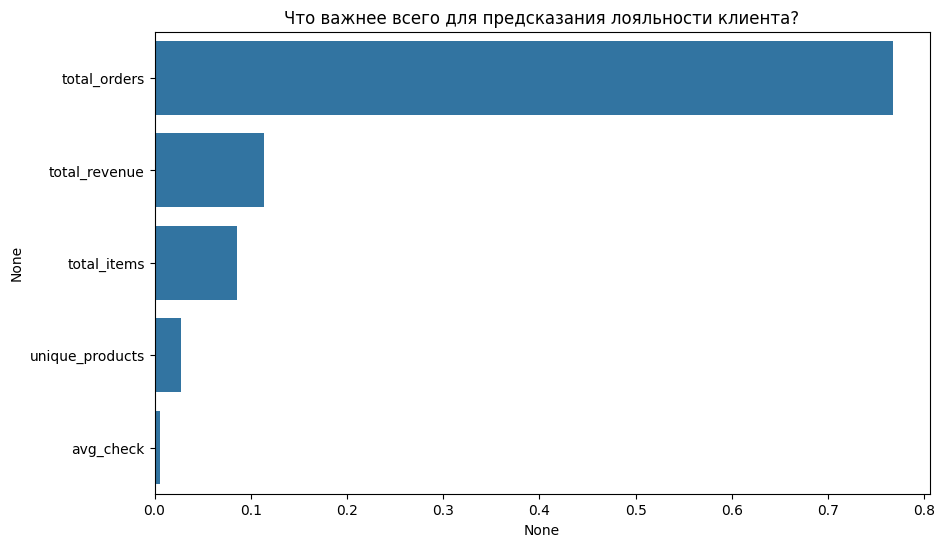

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Feature Engineering (Создаем признаки для модели)
ml_data = df.groupby('CustomerNo').agg({
    'TransactionNo': 'nunique', # Сколько раз покупал
    'Revenue': ['sum', 'mean'], # Сколько всего потратил и средний чек
    'Quantity': 'sum',          # Сколько товаров взял всего
    'ProductNo': 'nunique'      # Разнообразие корзины
})

ml_data.columns = ['total_orders', 'total_revenue', 'avg_check', 'total_items', 'unique_products']

# 2. Определение целевой переменной (Target)
ml_data['is_loyal'] = (ml_data['total_orders'] > 2).astype(int)

# 3. Подготовка выборок
X = ml_data.drop('is_loyal', axis=1)
y = ml_data['is_loyal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Обучение модели Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Оценка результатов
y_pred = model.predict(X_test)

print("--- Отчет по качеству модели ---")
print(classification_report(y_test, y_pred))

# 6. Визуализация важности признаков (Feature Importance)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title('Что важнее всего для предсказания лояльности клиента?')
plt.show()

In [13]:
import datetime as dt

# 1. RFM Анализ (Recency, Frequency, Monetary)
today = df['Date'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerNo').agg({
    'Date': lambda x: (today - x.max()).days,
    'TransactionNo': 'nunique',
    'Revenue': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Разделяем на 5 групп (квантили) — это база сегментации
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]) # Чем меньше дней, тем выше балл
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

print("Сегментация клиентов готова. Топ лояльных клиентов:")
print(rfm[rfm['RFM_Score'] == '555'].head())

Сегментация клиентов готова. Топ лояльных клиентов:
            Recency  Frequency   Monetary  R  F  M RFM_Score
CustomerNo                                                  
12347.0           3          8   38321.90  5  5  5       555
12362.0           4         13   24198.57  5  5  5       555
12417.0           4         12   17654.58  5  5  5       555
12423.0           1         10   14632.97  5  5  5       555
12433.0           1          7  115454.49  5  5  5       555


In [14]:
!pip install catboost optuna -q

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# 1. Готовим данные (усложняем признаки)
X = ml_data.drop('is_loyal', axis=1)
y = ml_data['is_loyal']

# 2. Обучаем CatBoost (Industry Standard)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_cb = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=0)
model_cb.fit(X_train, y_train)

# 3. Метрика ROC-AUC
roc_auc = roc_auc_score(y_test, model_cb.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 1.0000
